In [79]:
time

array([[0.0000e+00],
       [5.0000e-03],
       [1.1000e-02],
       ...,
       [4.1880e+01],
       [4.1885e+01],
       [4.1891e+01]])

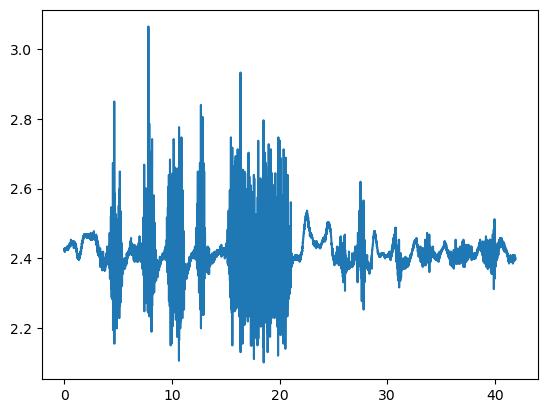

In [133]:
import pandas as pd
import numpy as np
import time as tt
import matplotlib.pyplot as plt

data = pd.read_csv('raw3.txt', header = None)
data = data.to_numpy().astype(float)
time = np.squeeze(data[0::2]*1e-3,axis=1)
raw_emg = np.squeeze(data[1::2]*(5/1023),axis=1)

plt.plot(time,raw_emg)

In [143]:
print(time[1:10])
print(1/np.mean(np.diff(time, axis=0)))

[0.005 0.011 0.016 0.021 0.026 0.032 0.037 0.043 0.049]
180.4206154066506


[0.11085208 0.9976687 ]
(7559,)


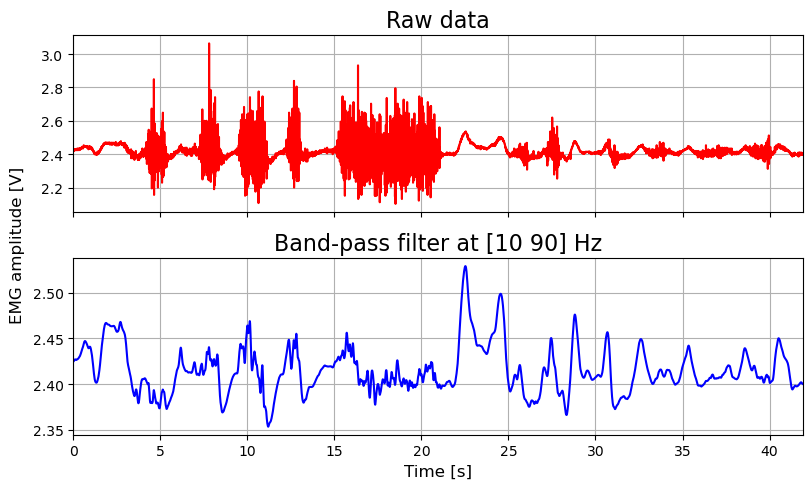

In [153]:
# band-pass Butterworth filter
from scipy.signal import butter, filtfilt
freq = (1/np.mean(np.diff(time, axis=0)))
print(([10, 90]/(freq/2)))
# b, a = butter(2, ([10, 90]/(freq/2)), btype = 'bandpass')
b, a = butter(2, (5/(freq/2)), btype = 'low')
dataf = filtfilt(b, a, raw_emg)
print(dataf.shape)

# plot data
fig, (ax1,ax2) = plt.subplots(2, 1, sharex = True, figsize = (8, 5))
ax1.plot(time, raw_emg, 'r')
ax1.set_title('Raw data', fontsize=16)
ax1.grid()
# ax1.set_ylim(400,600)
ax2.plot(time, dataf, 'b')
ax2.set_xlabel('Time [s]', fontsize=12)
ax2.set_xlim(time[0], time[-1])
# ax2.set_ylim(-100,100)
ax2.set_title('Band-pass filter at [10 90] Hz', fontsize=16)
fig.text(0, 0.5, 'EMG amplitude [V]', ha='center', va='center',
         rotation='vertical', fontsize=12)
# plt.locator_params(axis = 'both', nbins = 4)
ax2.grid()
plt.tight_layout()

In [136]:
# full-wave rectification
datafr = abs(dataf)
datafr.shape

(7559,)

0.0009980201721191406
0.0055426038634559405


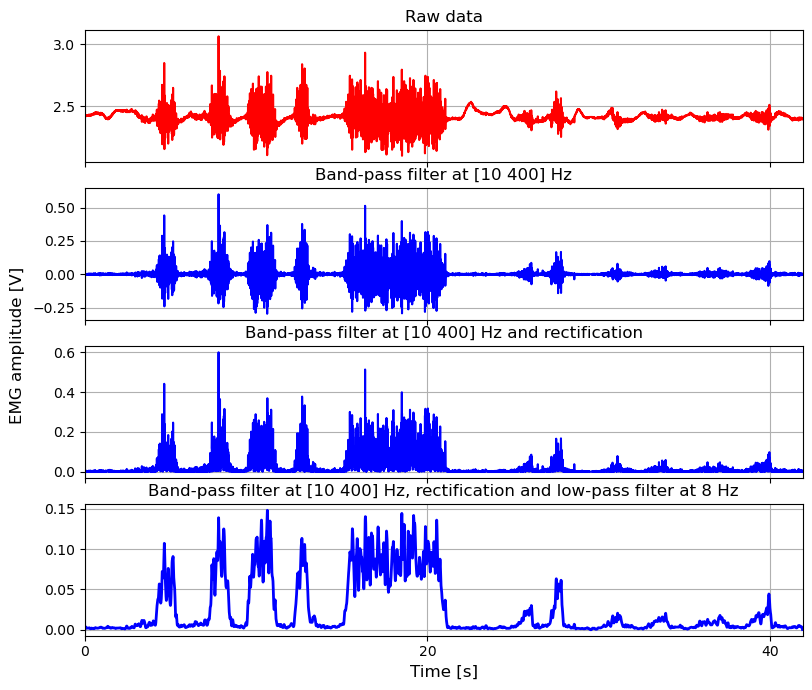

In [142]:
# low-pass Butterworth filter
b, a = butter(2, (8/(freq/2)), btype = 'low')
t = tt.time()
# do stuff
datafrle = filtfilt(b, a, datafr)
elapsed = tt.time() - t
print(elapsed)
print(np.mean(np.diff(time, axis=0)))
# plot data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, sharex = True, figsize = (8, 7))
ax1.plot(time, raw_emg, 'r')
ax1.set_title('Raw data', fontsize=12)
ax1.set_xlim(time[0], time[-1])
ax1.grid()
ax2.plot(time, dataf, 'b')
ax2.set_title('Band-pass filter at [10 400] Hz', fontsize=12)
ax2.grid()
ax3.plot(time, datafr, 'b')
ax3.set_title('Band-pass filter at [10 400] Hz and rectification', fontsize=12)
ax3.grid()
ax4.plot(time, datafrle, 'b', linewidth=2)
ax4.set_xlabel('Time [s]', fontsize=12)
ax4.set_title('Band-pass filter at [10 400] Hz, rectification and low-pass filter at 8 Hz',
              fontsize=12)
fig.text(0, 0.5, 'EMG amplitude [V]', ha='center', va='center',
         rotation='vertical', fontsize=12)
plt.locator_params(axis = 'both', nbins = 4)
ax4.grid()
plt.tight_layout(h_pad=.1)

In [111]:
def linear_envelope(x, freq=1000, fc_bp=[10, 400], fc_lp=8):
    r"""Calculate the linear envelope of a signal.

    Parameters
    ----------
    x     : 1D array_like
            raw signal
    freq  : number
            sampling frequency
    fc_bp : list [fc_h, fc_l], optional
            cutoff frequencies for the band-pass filter (in Hz)
    fc_lp : number, optional
            cutoff frequency for the low-pass filter (in Hz)

    Returns
    -------
    x     : 1D array_like
            linear envelope of the signal

    Notes
    -----
    A 2nd-order Butterworth filter with zero lag is used for the filtering.  

    See this notebook [1]_.

    References
    ----------
    .. [1] https://github.com/demotu/BMC/blob/master/notebooks/Electromyography.ipynb

    """
    
    import numpy as np
    from scipy.signal import butter, filtfilt
    
    if np.size(fc_bp) == 2:
        # band-pass filter
        b, a = butter(2, (fc_bp/(freq/2.)), btype = 'bandpass')
        x = filtfilt(b, a, x)   
    if np.size(fc_lp) == 1:
        # full-wave rectification
        x = abs(x)
        # low-pass Butterworth filter
        b, a = butter(2, (fc_lp/(freq/2.)), btype = 'low')
        x = filtfilt(b, a, x)
    
    return x

In [81]:
import sys
sys.path.insert(1, r'./../')
from detect_onset import detect_onset

C:\Users\zoufaond\Jupyter\Arduino\Arduino\EMG\detect_onset.py:10: UserWarning: A newest version is available at https://pypi.org/project/detecta/
  warnings.warn('A newest version is available at https://pypi.org/project/detecta/')


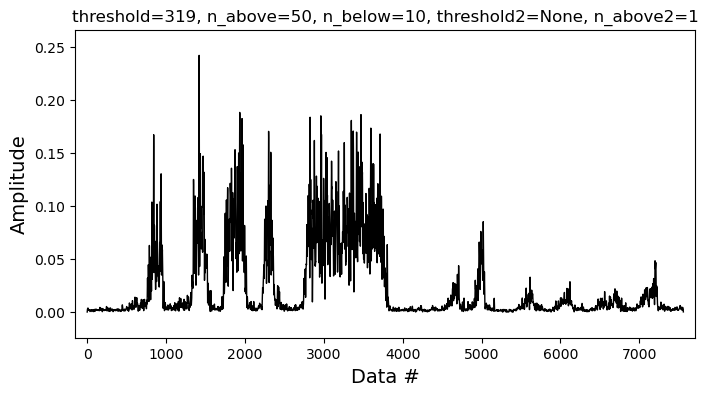

array([], dtype=float64)

In [87]:
threshold=2
window=50
data2 = linear_envelope(raw_emg.T, freq, fc_bp=[20, 90], fc_lp=20)
inds = detect_onset(data2.T, threshold=threshold*np.std(data[0:200]),
                    n_above=window, n_below=10, show=True)
inds

In [88]:
def tkeo(x):
    r"""Calculates the Teager–Kaiser Energy operator.

    Parameters
    ----------
    x : 1D array_like
        raw signal

    Returns
    -------
    y : 1D array_like
        signal processed by the Teager–Kaiser Energy operator

    Notes
    -----

    See this notebook [1]_.

    References
    ----------
    .. [1] https://github.com/demotu/BMC/blob/master/notebooks/Electromyography.ipynb

    """
    x = np.asarray(x)
    y = np.copy(x)
    # Teager–Kaiser Energy operator
    y[1:-1] = x[1:-1]*x[1:-1] - x[:-2]*x[2:]
    # correct the data in the extremities
    y[0], y[-1] = y[1], y[-2]
    
    return y

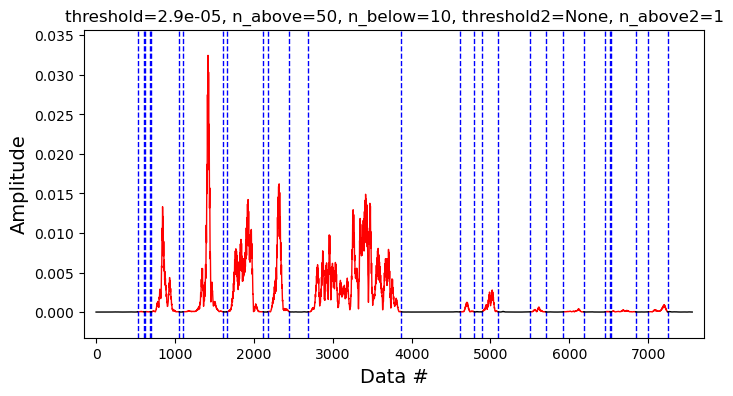

array([[ 526,  607],
       [ 624,  689],
       [ 702, 1054],
       [1102, 1614],
       [1654, 2120],
       [2175, 2451],
       [2690, 3872],
       [4615, 4795],
       [4895, 5098],
       [5507, 5701],
       [5925, 6184],
       [6454, 6517],
       [6532, 6841],
       [7002, 7245]], dtype=int64)

In [101]:
threshold = 2
window = 50
data3 = tkeo(dataf.T)
data4 = linear_envelope(data3.T, freq, fc_bp=[10, 15], fc_lp=20)
inds2 = detect_onset(data4.T, threshold=threshold*np.std(data3[0:200]),
                     n_above=window, n_below=10, show=True)
inds2